In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [3]:
kladdress = "Kuala Lumpur, KL"

klgeolocator = Nominatim(user_agent = "kl_explorer")
kllocation = klgeolocator.geocode(kladdress)
kllatitude = kllocation.latitude
kllongitude = kllocation.longitude

print(("Latitude and Longitude of Kuala Lumpur are {} and {}").format(kllatitude, kllongitude))

Latitude and Longitude of Kuala Lumpur are 3.14822295 and 101.701367802485


In [4]:
CLIENT_ID = "VTZEHLUP5HS4NUJDPOCWUY2IDLEBC2OMMD5ZMBHUR4VRGCOV"
CLIENT_SECRET = "W4SM1XU0THYM3EPZE1MLSVKPERLKY30EI32NXKY2MTKJ3Z5R" 
VERSION = "20190514"

print("Your credentials:" )
print("Client ID : " + CLIENT_ID)
print("Client Secret : " + CLIENT_SECRET)

Your credentials:
Client ID : VTZEHLUP5HS4NUJDPOCWUY2IDLEBC2OMMD5ZMBHUR4VRGCOV
Client Secret : W4SM1XU0THYM3EPZE1MLSVKPERLKY30EI32NXKY2MTKJ3Z5R


In [5]:
LIMIT = 200
radius = 1000

url1 = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
       CLIENT_ID, CLIENT_SECRET, VERSION, kllatitude, kllongitude, radius, LIMIT) 

In [6]:
url1

'https://api.foursquare.com/v2/venues/explore?&client_id=VTZEHLUP5HS4NUJDPOCWUY2IDLEBC2OMMD5ZMBHUR4VRGCOV&client_secret=W4SM1XU0THYM3EPZE1MLSVKPERLKY30EI32NXKY2MTKJ3Z5R&v=20190514&ll=3.14822295,101.701367802485&radius=1000&limit=200'

In [7]:
results = requests.get(url1).json()

In [8]:
klvenues = results["response"]["groups"][0]["items"]

In [9]:
klnearby_venues = json_normalize(klvenues)

In [10]:
klfiltered_columns = ["venue.name", "venue.categories", "venue.location.lat", "venue.location.lng"]

In [11]:
klnearby_venues = klnearby_venues.loc[:, klfiltered_columns]

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
klnearby_venues["venue.categories"] = klnearby_venues.apply(get_category_type, axis = 1)

In [14]:
klnearby_venues.head(10)

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,BackHome Kuala Lumpur,Hostel,3.148732,101.697887
1,Pampas Reserve Grill & Bar,Latin American Restaurant,3.150222,101.704355
2,Family Mart,Convenience Store,3.145195,101.698606
3,Restoran Santa,South Indian Restaurant,3.149083,101.698156
4,Betel Leaf,Chettinad Restaurant,3.149543,101.697763
5,Kedai Mamak Husin,Halal Restaurant,3.144556,101.704214
6,茨厂街驰名罗汉果龙眼冰糖炖冬瓜 (Air Mata Kucing),Food Truck,3.144283,101.697753
7,Urbanscapes House,Exhibit,3.146803,101.696028
8,Saravanaa Bhavan,Indian Restaurant,3.149231,101.697475
9,Starbucks,Coffee Shop,3.147224,101.699555


In [15]:
klnearby_venues.columns = [col.split(".")[-1] for col in klnearby_venues.columns]

In [16]:
klnearby_venues_restaurant = klnearby_venues[klnearby_venues["categories"].str.contains("Restaurant")]

In [17]:
klnearby_venues_restaurant.head()

,name,categories,lat,lng
1,Pampas Reserve Grill & Bar,Latin American Restaurant,3.150222,101.704355
3,Restoran Santa,South Indian Restaurant,3.149083,101.698156
4,Betel Leaf,Chettinad Restaurant,3.149543,101.697763
5,Kedai Mamak Husin,Halal Restaurant,3.144556,101.704214
8,Saravanaa Bhavan,Indian Restaurant,3.149231,101.697475


In [18]:
# one hot encoding
kl_restaurant = pd.get_dummies(klnearby_venues_restaurant[['categories']], prefix="", prefix_sep="")

In [19]:
kl_restaurant_chart = kl_restaurant.sum()

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

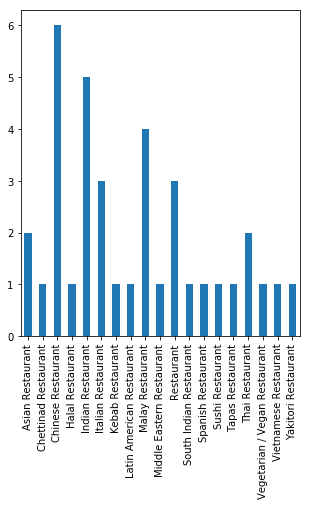

In [21]:
kl_restaurant_chart.plot(kind="bar", figsize = (5, 6))

In [21]:
klnearby_venues_restaurant.head(2)

,name,categories,lat,lng
1,Pampas Reserve Grill & Bar,Latin American Restaurant,3.150222,101.704355
3,Restoran Santa,South Indian Restaurant,3.149083,101.698156


In [22]:
map_kl = folium.Map(location = [kllatitude, kllongitude], zoom_start = 15)

for lat, lng, cat in zip(klnearby_venues_restaurant["lat"], klnearby_venues_restaurant["lng"], klnearby_venues_restaurant["categories"]):
    label = "{}".format(cat)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng],
    radius = 5,
    fill = True,
    fill_color = "#3186cc",
    fill_opacity = 0.7,
    popup = label).add_to(map_kl)

map_kl       

In [23]:
kl_data = pd.read_excel("Kuala Lumpur District.xlsx")

In [24]:
kl_data

,City,District,Latitude,Longitude
0,Kuala Lumpur,Bukit Bintang,3.146680,101.71119
1,Kuala Lumpur,Titiwangsa,3.177880,101.70677
2,Kuala Lumpur,Setiawangsa,3.185250,101.74646
3,Kuala Lumpur,Wangsa Maju,3.199490,101.74001
4,Kuala Lumpur,Batu,3.206600,101.68200
5,Kuala Lumpur,Kepong,3.214000,101.63560
6,Kuala Lumpur,Segambut,3.191700,101.67340
7,Kuala Lumpur,Lembah Pantai,3.125100,101.66830
8,Kuala Lumpur,Seputeh,3.108100,101.67540
9,Kuala Lumpur,Bandar Tun Razak,3.092000,101.72110


In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
# type your answer here

kl_venues = getNearbyVenues(names=kl_data['District'],
                                   latitudes=kl_data['Latitude'],
                                   longitudes=kl_data['Longitude']
                                  )



Bukit Bintang
Titiwangsa
Setiawangsa
Wangsa Maju
Batu
Kepong
Segambut
Lembah Pantai
Seputeh
Bandar Tun Razak
Cheras


In [27]:
kl_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bukit Bintang,3.14668,101.71119,Sobaya Shige,3.146042,101.711673,Udon Restaurant
1,Bukit Bintang,3.14668,101.71119,Isetan The Japan Store,3.145937,101.712037,Department Store
2,Bukit Bintang,3.14668,101.71119,The Tokyo Restaurant,3.146118,101.712023,Café
3,Bukit Bintang,3.14668,101.71119,The KL Journal,3.148033,101.710645,Hotel
4,Bukit Bintang,3.14668,101.71119,J’s Gate Dining,3.146570,101.711746,Japanese Restaurant


In [28]:
# one hot encoding
kl_onehot = pd.get_dummies(kl_venues[['Venue Category']], prefix="", prefix_sep="")

In [29]:
kl_onehot.head()

,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Auto Garage,BBQ Joint,Bakery,Bar,Basketball Court,Beer Bar,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Bubble Tea Shop,Buffet,Burger Joint,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Electronics Store,Fast Food Restaurant,Fishing Store,Flea Market,Flower Shop,Food,Food Court,Food Truck,Frozen Yogurt Shop,Garden,General Entertainment,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Halal Restaurant,Harbor / Marina,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Light Rail Station,Lingerie Store,Lounge,Malay Restaurant,Mamak Restaurant,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Motel,Motorcycle Shop,Mountain,Multiplex,Music Store,Music Venue,Night Market,Noodle House,Other Great Outdoors,Park,Perfume Shop,Pharmacy,Pizza Place,Playground,Pool Hall,Ramen Restaurant,Restaurant,Sandwich Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Stables,Stadium,Steakhouse,Street Food Gathering,Sushi Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Toy / Game Store,Track,Track Stadium,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
# add neighborhood column back to dataframe
kl_onehot['District'] = kl_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [kl_onehot.columns[-1]] + list(kl_onehot.columns[:-1])
kl_onehot = kl_onehot[fixed_columns]

kl_onehot.head()

,District,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Auto Garage,BBQ Joint,Bakery,Bar,Basketball Court,Beer Bar,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Bubble Tea Shop,Buffet,Burger Joint,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Electronics Store,Fast Food Restaurant,Fishing Store,Flea Market,Flower Shop,Food,Food Court,Food Truck,Frozen Yogurt Shop,Garden,General Entertainment,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Halal Restaurant,Harbor / Marina,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Light Rail Station,Lingerie Store,Lounge,Malay Restaurant,Mamak Restaurant,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Motel,Motorcycle Shop,Mountain,Multiplex,Music Store,Music Venue,Night Market,Noodle House,Other Great Outdoors,Park,Perfume Shop,Pharmacy,Pizza Place,Playground,Pool Hall,Ramen Restaurant,Restaurant,Sandwich Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Stables,Stadium,Steakhouse,Street Food Gathering,Sushi Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Toy / Game Store,Track,Track Stadium,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Women's Store
0,Bukit Bintang,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,Bukit Bintang,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bukit Bintang,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bukit Bintang,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bukit Bintang,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
kl_grouped = kl_onehot.groupby('District').mean().reset_index()
kl_grouped

,District,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Auto Garage,BBQ Joint,Bakery,Bar,Basketball Court,Beer Bar,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Bubble Tea Shop,Buffet,Burger Joint,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Electronics Store,Fast Food Restaurant,Fishing Store,Flea Market,Flower Shop,Food,Food Court,Food Truck,Frozen Yogurt Shop,Garden,General Entertainment,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Halal Restaurant,Harbor / Marina,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Light Rail Station,Lingerie Store,Lounge,Malay Restaurant,Mamak Restaurant,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Motel,Motorcycle Shop,Mountain,Multiplex,Music Store,Music Venue,Night Market,Noodle House,Other Great Outdoors,Park,Perfume Shop,Pharmacy,Pizza Place,Playground,Pool Hall,Ramen Restaurant,Restaurant,Sandwich Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soup Place,South Indian Restaurant,Spa,Spanish Restaurant,Stables,Stadium,Steakhouse,Street Food Gathering,Sushi Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Toy / Game Store,Track,Track Stadium,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Women's Store
0,Bandar Tun Razak,0.000000,0.000000,0.058824,0.0,0.000000,0.058824,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.117647,0.058824,0.00,0.000000,0.00,0.117647,0.058824,0.000000,0.000000,0.058824,0.00000,0.058824,0.058824,0.058824,0.00,0.000000,0.000000,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.00000,0.00,0.000000,0.0,0.00000,0.058824,0.00000,0.00,0.00,0.00,0.00,0.00000,0.00000,0.000000,0.00000,0.00,0.00,0.058824,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.00,0.058824,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.00,0.00,0.00000,0.000000,0.00000,0.00,0.058824,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00
1,Batu,0.000000,0.000000,0.200000,0.2,0.000000,0.000000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.200000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.00000,0.00,0.000000,0.0,0.00000,0.000000,0.00000,0.00,0.00,0.00,0.00,0.00000,0.00000,0.000000,0.00000,0.00,0.00,0.200000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.000000,0.00000,0.00,0.200000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.00,0.00,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00
2,Bukit Bintang,0.000000,0.000000,0.030000,0.0,0.010000,0.010000,0.020000,0.000000,0.01,0.00000,0.010000,0.030000,0.00000,0.01,0.000000,0.000000,0.000000,0.030000,0.030000,0.040000,0.050000,0.000000,0.010000,0.020000,0.01,0.030000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.01,0.000000,0.000000,0.01,0.000000,0.00000,0.01,0.000000,0.000000,0.00000,0.01,0.050000,0.0,0.04000,0.000000,0.00000,0.01,0.01,0.04,0.03,0.03000,0.01000,0.000000,0.00000,0.01,0.02,0.010000,0.000000,0.0

In [32]:
num_top_venues = 5

for dist in kl_grouped['District']:
    print("----"+dist+"----")
    temp = kl_grouped[kl_grouped['District'] == dist].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bandar Tun Razak----
               venue  freq
0              Diner  0.12
1  Convenience Store  0.12
2     Cosmetics Shop  0.06
3        Flea Market  0.06
4       Burger Joint  0.06


----Batu----
                  venue  freq
0  Fast Food Restaurant   0.2
1          Night Market   0.2
2      Asian Restaurant   0.2
3           Auto Garage   0.2
4      Malay Restaurant   0.2


----Bukit Bintang----
                 venue  freq
0          Coffee Shop  0.05
1                Hotel  0.05
2       Clothing Store  0.04
3       Ice Cream Shop  0.04
4  Japanese Restaurant  0.04


----Cheras----
                 venue  freq
0  Arts & Crafts Store  0.33
1           Food Truck  0.33
2          Flea Market  0.33
3     Malay Restaurant  0.00
4     Mamak Restaurant  0.00


----Kepong----
                  venue  freq
0    Chinese Restaurant  0.29
1      Asian Restaurant  0.10
2          Noodle House  0.06
3          Dessert Shop  0.06
4  Fast Food Restaurant  0.04


----Lembah Pantai----
        

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
districts_venues_sorted = pd.DataFrame(columns=columns)
districts_venues_sorted['District'] = kl_grouped['District']

for ind in np.arange(kl_grouped.shape[0]):
    districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kl_grouped.iloc[ind, :], num_top_venues)

districts_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bandar Tun Razak,Diner,Convenience Store,Malay Restaurant,Burger Joint,Flea Market,Night Market,Cosmetics Shop,Food Truck,Indian Restaurant,Bakery
1,Batu,Fast Food Restaurant,Auto Garage,Night Market,Malay Restaurant,Asian Restaurant,Flower Shop,Food,Food Court,Hainan Restaurant,Food Truck
2,Bukit Bintang,Coffee Shop,Hotel,Ice Cream Shop,Clothing Store,Japanese Restaurant,Boutique,Chinese Restaurant,Café,Jewelry Store,Middle Eastern Restaurant
3,Cheras,Arts & Crafts Store,Flea Market,Food Truck,Hainan Restaurant,Fishing Store,Flower Shop,Food,Food Court,Frozen Yogurt Shop,Garden
4,Kepong,Chinese Restaurant,Asian Restaurant,Dessert Shop,Noodle House,Café,Fast Food Restaurant,Coffee Shop,Comfort Food Restaurant,Malay Restaurant,Clothing Store
5,Lembah Pantai,Indian Restaurant,Malay Restaurant,Hotel,Chinese Restaurant,Other Great Outdoors,Mamak Restaurant,South Indian Restaurant,Garden,Pharmacy,Vegetarian / Vegan Restaurant
6,Segambut,Chinese Restaurant,Diner,Motorcycle Shop,Pizza Place,Boutique,Malay Restaurant,Pool Hall,Electronics Store,BBQ Joint,Asian Restaurant
7,Seputeh,Chinese Restaurant,Japanese Restaurant,Thai Restaurant,Hotpot Restaurant,Food Truck,Malay Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Food,Food Court
8,Setiawangsa,Fast Food Restaurant,Dessert Shop,Mountain,Thai Restaurant,Bar,Basketball Court,Buffet,Food Truck,Food Court,Food
9,Titiwangsa,Malay Restaurant,Park,Gym,Harbor / Marina,Mexican Restaurant,Skate Park,Restaurant,Multiplex,Halal Restaurant,Stables


In [35]:
# set number of clusters
kclusters = 2

kl_grouped_clustering = kl_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kl_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:11] 

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [36]:
# add clustering labels
districts_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kl_merged = kl_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kl_merged = kl_merged.join(districts_venues_sorted.set_index('District'), on='District')

kl_merged # check the last columns!

,City,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kuala Lumpur,Bukit Bintang,3.146680,101.71119,0,Coffee Shop,Hotel,Ice Cream Shop,Clothing Store,Japanese Restaurant,Boutique,Chinese Restaurant,Café,Jewelry Store,Middle Eastern Restaurant
1,Kuala Lumpur,Titiwangsa,3.177880,101.70677,0,Malay Restaurant,Park,Gym,Harbor / Marina,Mexican Restaurant,Skate Park,Restaurant,Multiplex,Halal Restaurant,Stables
2,Kuala Lumpur,Setiawangsa,3.185250,101.74646,0,Fast Food Restaurant,Dessert Shop,Mountain,Thai Restaurant,Bar,Basketball Court,Buffet,Food Truck,Food Court,Food
3,Kuala Lumpur,Wangsa Maju,3.199490,101.74001,0,Spa,Ice Cream Shop,Thai Restaurant,Dessert Shop,Electronics Store,Coffee Shop,Light Rail Station,Hookah Bar,Comfort Food Restaurant,Sandwich Place
4,Kuala Lumpur,Batu,3.206600,101.68200,0,Fast Food Restaurant,Auto Garage,Night Market,Malay Restaurant,Asian Restaurant,Flower Shop,Food,Food Court,Hainan Restaurant,Food Truck
5,Kuala Lumpur,Kepong,3.214000,101.63560,0,Chinese Restaurant,Asian Restaurant,Dessert Shop,Noodle House,Café,Fast Food Restaurant,Coffee Shop,Comfort Food Restaurant,Malay Restaurant,Clothing Store
6,Kuala Lumpur,Segambut,3.191700,101.67340,0,Chinese Restaurant,Diner,Motorcycle Shop,Pizza Place,Boutique,Malay Restaurant,Pool Hall,Electronics Store,BBQ Joint,Asian Restaurant
7,Kuala Lumpur,Lembah Pantai,3.125100,101.66830,0,Indian Restaurant,Malay Restaurant,Hotel,Chinese Restaurant,Other Great Outdoors,Mamak Restaurant,South Indian Restaurant,Garden,Pharmacy,Vegetarian / Vegan Restaurant
8,Kuala Lumpur,Seputeh,3.108100,101.67540,0,Chinese Restaurant,Japanese Restaurant,Thai Restaurant,Hotpot Restaurant,Food Truck,Malay Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Food,Food Court
9,Kuala Lumpur,Bandar Tun Razak,3.092000,101.72110,0,Diner,Convenience Store,Malay Restaurant,Burger Joint,Flea Market,Night Market,Cosmetics Shop,Food Truck,Indian Restaurant,Bakery


In [37]:
# create map
map_clusters = folium.Map(location=[kllatitude, kllongitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_merged['Latitude'], kl_merged['Longitude'], kl_merged['District'], kl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters